In [1]:
import numpy as np
import matplotlib.pyplot as plt

from activation_classifier import ActivationClassifier

import torch
import hypernetx as hnx
import networkx as nx

from models.hypergraph_models import HyperGCN, MyHyperGCN, HyperResidGCN

from train_utils import train_eval_loop, get_activations
from vis_utils import plot_activations_by_class, plot_cluster_activations
from graph_utils import get_local_hypergraph, plot_samples

from load_coraca import get_coraca_hypergraph

# Cora Coauthorship hypergraph

In [2]:
hgraph_coraca = get_coraca_hypergraph() # load with default split size and seed
num_classes = 7

In [3]:
print(hgraph_coraca)
print(hgraph_coraca.shape)
print(hgraph_coraca.x.shape)
print(hgraph_coraca.y.shape)
print(hgraph_coraca.H.shape)
print(hgraph_coraca.edge_index.shape)

Cora Co-Authorship, <class 'hypernetx.classes.hypergraph.Hypergraph'>
(2708, 3780)
torch.Size([2708, 1433])
torch.Size([2708])
torch.Size([2708, 3780])
torch.Size([2, 7293])


In [4]:
print(hgraph_coraca.H)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [5]:
print(hgraph_coraca.edge_index)

tensor([[   0,    0,    1,  ..., 2706, 2707, 2707],
        [1048, 1072,  780,  ..., 2970,  986, 2971]])


In [6]:
print(len(hgraph_coraca.incidence_dict))
# print(hgraph_coraca.incidence_dict.keys())
# print(hgraph_coraca.incidence_dict.values())

3780


# Device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def put_hgraph_attributes_on_device(hgraph, device) -> None:
    hgraph.train_mask = hgraph.train_mask.to(device)
    hgraph.val_mask = hgraph.val_mask.to(device)
    hgraph.test_mask = hgraph.test_mask.to(device)
    hgraph.x = hgraph.x.to(device)
    hgraph.y = hgraph.y.to(device)
    hgraph.H = hgraph.H.to(device)
    hgraph.edge_index = hgraph.edge_index.to(device)

# GCN

In [16]:
model_gcn = HyperGCN(input_dim=hgraph_coraca.x.shape[1], hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=False)
model_gcn.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gcn,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 10 with train loss: 1.589 train acc: 0.346 val acc: 0.343
Epoch 20 with train loss: 1.055 train acc: 0.736 val acc: 0.700
Epoch 30 with train loss: 0.566 train acc: 0.882 val acc: 0.811
Epoch 40 with train loss: 0.309 train acc: 0.917 val acc: 0.833
Epoch 50 with train loss: 0.199 train acc: 0.942 val acc: 0.843
Epoch 60 with train loss: 0.140 train acc: 0.956 val acc: 0.838
Epoch 70 with train loss: 0.103 train acc: 0.973 val acc: 0.829
Epoch 80 with train loss: 0.079 train acc: 0.987 val acc: 0.829
Epoch 90 with train loss: 0.062 train acc: 0.992 val acc: 0.823
Epoch 100 with train loss: 0.051 train acc: 0.996 val acc: 0.818
Final train acc: 0.996 | val acc: 0.818 | test acc: 0.833 


# GAT

In [15]:
model_gat = HyperGCN(input_dim=1433, hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True)
model_gat.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 10 with train loss: 1.752 train acc: 0.307 val acc: 0.313
Epoch 20 with train loss: 1.511 train acc: 0.442 val acc: 0.378
Epoch 30 with train loss: 1.225 train acc: 0.574 val acc: 0.442
Epoch 40 with train loss: 0.945 train acc: 0.744 val acc: 0.572
Epoch 50 with train loss: 0.707 train acc: 0.849 val acc: 0.663
Epoch 60 with train loss: 0.524 train acc: 0.913 val acc: 0.694
Epoch 70 with train loss: 0.390 train acc: 0.942 val acc: 0.709
Epoch 80 with train loss: 0.293 train acc: 0.962 val acc: 0.722
Epoch 90 with train loss: 0.223 train acc: 0.979 val acc: 0.730
Epoch 100 with train loss: 0.172 train acc: 0.985 val acc: 0.730
Final train acc: 0.985 | val acc: 0.730 | test acc: 0.737 


In [33]:
model_gat = HyperGCN(input_dim=1433, hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True)
model_gat.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.1,
    num_epochs=100,
)

Epoch 10 with train loss: 0.771 train acc: 0.838 val acc: 0.660
Epoch 20 with train loss: 0.125 train acc: 0.981 val acc: 0.753
Epoch 30 with train loss: 0.027 train acc: 0.996 val acc: 0.731
Epoch 40 with train loss: 0.009 train acc: 0.999 val acc: 0.715
Epoch 50 with train loss: 0.004 train acc: 0.999 val acc: 0.718
Epoch 60 with train loss: 0.003 train acc: 1.000 val acc: 0.709
Epoch 70 with train loss: 0.002 train acc: 1.000 val acc: 0.712
Epoch 80 with train loss: 0.002 train acc: 1.000 val acc: 0.716
Epoch 90 with train loss: 0.001 train acc: 1.000 val acc: 0.718
Epoch 100 with train loss: 0.001 train acc: 1.000 val acc: 0.716
Final train acc: 1.000 | val acc: 0.716 | test acc: 0.722 


In [34]:
model_gat = HyperGCN(input_dim=1433, hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True, dropout=0.7)
model_gat.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.1,
    num_epochs=100,
)

Epoch 10 with train loss: 1.134 train acc: 0.702 val acc: 0.558
Epoch 20 with train loss: 0.464 train acc: 0.948 val acc: 0.755
Epoch 30 with train loss: 0.223 train acc: 0.985 val acc: 0.773
Epoch 40 with train loss: 0.116 train acc: 0.994 val acc: 0.773
Epoch 50 with train loss: 0.078 train acc: 0.997 val acc: 0.775
Epoch 60 with train loss: 0.052 train acc: 0.999 val acc: 0.768
Epoch 70 with train loss: 0.055 train acc: 0.999 val acc: 0.768
Epoch 80 with train loss: 0.039 train acc: 0.999 val acc: 0.777
Epoch 90 with train loss: 0.034 train acc: 0.999 val acc: 0.771
Epoch 100 with train loss: 0.046 train acc: 0.999 val acc: 0.768
Final train acc: 0.999 | val acc: 0.768 | test acc: 0.758 


In [35]:
model_gat = HyperGCN(input_dim=1433, hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True, attention_mode='edge')
model_gat.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.1,
    num_epochs=100,
)

Epoch 10 with train loss: 1.501 train acc: 0.432 val acc: 0.375
Epoch 20 with train loss: 1.086 train acc: 0.621 val acc: 0.533
Epoch 30 with train loss: 0.659 train acc: 0.829 val acc: 0.724
Epoch 40 with train loss: 0.333 train acc: 0.925 val acc: 0.774
Epoch 50 with train loss: 0.152 train acc: 0.971 val acc: 0.775
Epoch 60 with train loss: 0.075 train acc: 0.984 val acc: 0.775
Epoch 70 with train loss: 0.039 train acc: 0.993 val acc: 0.780
Epoch 80 with train loss: 0.024 train acc: 0.996 val acc: 0.778
Epoch 90 with train loss: 0.016 train acc: 0.998 val acc: 0.774
Epoch 100 with train loss: 0.013 train acc: 0.999 val acc: 0.777
Final train acc: 0.999 | val acc: 0.777 | test acc: 0.778 


In [38]:
model_gat = HyperGCN(input_dim=1433, hidden_dim=128, output_dim=num_classes, num_layers=2, use_attention=True, attention_mode='edge', dropout=0.7)
model_gat.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gat,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.1,
    num_epochs=100,
)

Epoch 10 with train loss: 1.575 train acc: 0.383 val acc: 0.356
Epoch 20 with train loss: 1.290 train acc: 0.538 val acc: 0.484
Epoch 30 with train loss: 0.966 train acc: 0.754 val acc: 0.663
Epoch 40 with train loss: 0.706 train acc: 0.860 val acc: 0.762
Epoch 50 with train loss: 0.474 train acc: 0.915 val acc: 0.808
Epoch 60 with train loss: 0.390 train acc: 0.930 val acc: 0.814
Epoch 70 with train loss: 0.287 train acc: 0.942 val acc: 0.820
Epoch 80 with train loss: 0.230 train acc: 0.964 val acc: 0.829
Epoch 90 with train loss: 0.189 train acc: 0.971 val acc: 0.835
Epoch 100 with train loss: 0.163 train acc: 0.976 val acc: 0.838
Final train acc: 0.976 | val acc: 0.838 | test acc: 0.833 


# GCN (mine)

My hypergraph-conv-layer implementation.

In [9]:
model_gcn_my = MyHyperGCN(input_dim=1433, output_dim=num_classes, hidden_dim=128, num_layers=2)
model_gcn_my.to(device)
put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gcn_my,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=50,
)

Epoch 0 with train loss: 1.957 train acc: 0.160 val acc: 0.167
Epoch 10 with train loss: 1.684 train acc: 0.313 val acc: 0.294
Epoch 20 with train loss: 1.314 train acc: 0.711 val acc: 0.650
Epoch 30 with train loss: 0.856 train acc: 0.787 val acc: 0.721
Epoch 40 with train loss: 0.519 train acc: 0.878 val acc: 0.801
Final test acc: 0.787


# Deep-HGCN (residual connect)

In [11]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=128, num_layers=2, alpha=0, beta=0, dropout=0)
model_gcn_resid.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 10 with train loss: 1.407 train acc: 0.467 val acc: 0.476
Epoch 20 with train loss: 0.470 train acc: 0.870 val acc: 0.762
Epoch 30 with train loss: 0.138 train acc: 0.957 val acc: 0.801
Epoch 40 with train loss: 0.038 train acc: 0.992 val acc: 0.799
Epoch 50 with train loss: 0.011 train acc: 0.999 val acc: 0.793
Epoch 60 with train loss: 0.004 train acc: 1.000 val acc: 0.790
Epoch 70 with train loss: 0.002 train acc: 1.000 val acc: 0.792
Epoch 80 with train loss: 0.001 train acc: 1.000 val acc: 0.792
Epoch 90 with train loss: 0.001 train acc: 1.000 val acc: 0.787
Epoch 100 with train loss: 0.000 train acc: 1.000 val acc: 0.786
Final train acc: 1.000 | val acc: 0.786 | test acc: 0.781 


In [13]:
model_gcn_resid = HyperResidGCN(input_dim=1433, output_dim=num_classes, hidden_dim=128, num_layers=2, alpha=0.2, beta=0, dropout=0.5)
model_gcn_resid.to(device)

put_hgraph_attributes_on_device(hgraph_coraca, device)

train_stats = train_eval_loop(
    model=model_gcn_resid,
    hgraph=hgraph_coraca,
    train_mask=hgraph_coraca.train_mask,
    val_mask=hgraph_coraca.val_mask,
    test_mask=hgraph_coraca.test_mask,
    lr=0.01,
    num_epochs=100,
)

Epoch 10 with train loss: 1.632 train acc: 0.314 val acc: 0.319
Epoch 20 with train loss: 0.621 train acc: 0.840 val acc: 0.728
Epoch 30 with train loss: 0.186 train acc: 0.958 val acc: 0.808
Epoch 40 with train loss: 0.062 train acc: 0.993 val acc: 0.808
Epoch 50 with train loss: 0.027 train acc: 1.000 val acc: 0.808
Epoch 60 with train loss: 0.013 train acc: 1.000 val acc: 0.795
Epoch 70 with train loss: 0.010 train acc: 1.000 val acc: 0.793
Epoch 80 with train loss: 0.005 train acc: 1.000 val acc: 0.809
Epoch 90 with train loss: 0.004 train acc: 1.000 val acc: 0.801
Epoch 100 with train loss: 0.005 train acc: 0.999 val acc: 0.804
Final train acc: 0.999 | val acc: 0.804 | test acc: 0.789 


# Activations - basic GCN

In [17]:
model_coraca = model_gcn

In [32]:
activations_gcn = {}

model_coraca.gcn_layers[0].register_forward_hook(get_activations('conv0', activations_gcn))
model_coraca.gcn_layers[1].register_forward_hook(get_activations('conv1', activations_gcn))

In [33]:
model_gcn.eval()
with torch.no_grad():
    out = model_coraca(hgraph_coraca)

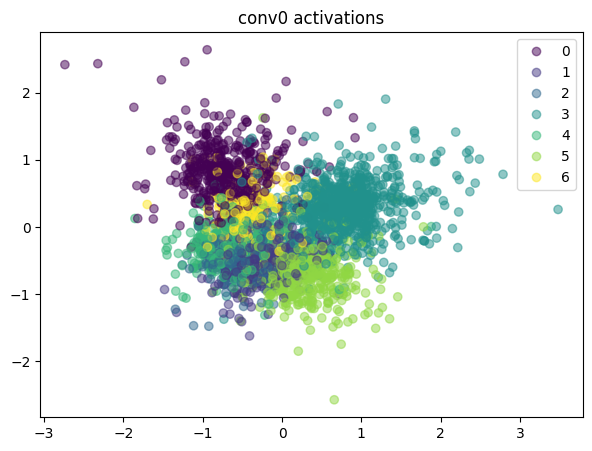

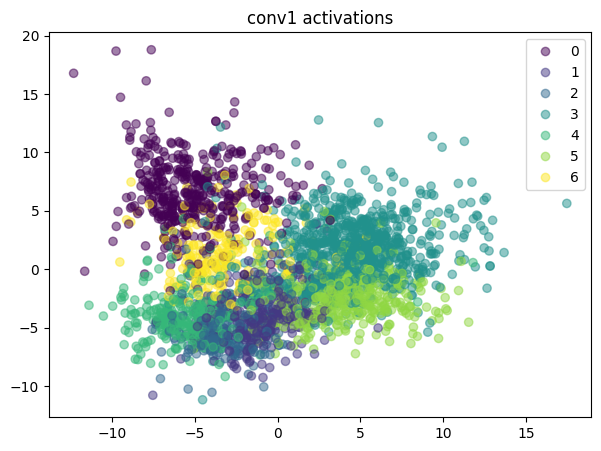

In [34]:
plot_activations_by_class(activations_gcn, hgraph_coraca.y)

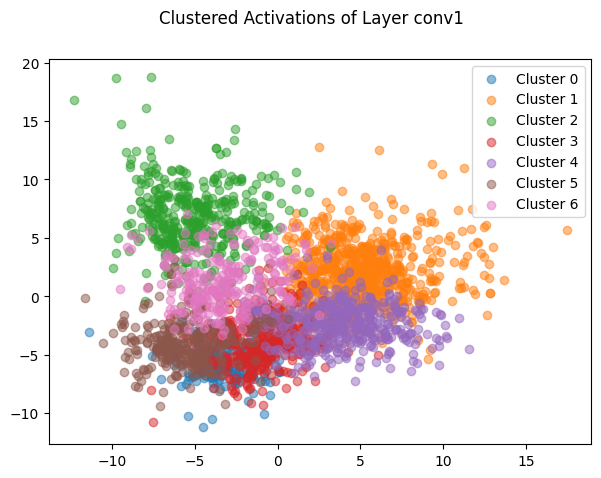

In [35]:
activ_gcn, kmeans_model_gcn = plot_cluster_activations(activations_gcn, 'conv1', num_clusters=7)

# Activations - residual GCN

In [36]:
activations_gcnresid = {}

model_gcn_resid.gcn_layers[0].register_forward_hook(get_activations('conv0', activations_gcnresid))
model_gcn_resid.gcn_layers[1].register_forward_hook(get_activations('conv1', activations_gcnresid))
model_gcn_resid.fc_out.register_forward_hook(get_activations('fc_out', activations_gcnresid))

model_gcn_resid.eval()
with torch.no_grad():
    out = model_gcn_resid(hgraph_coraca)

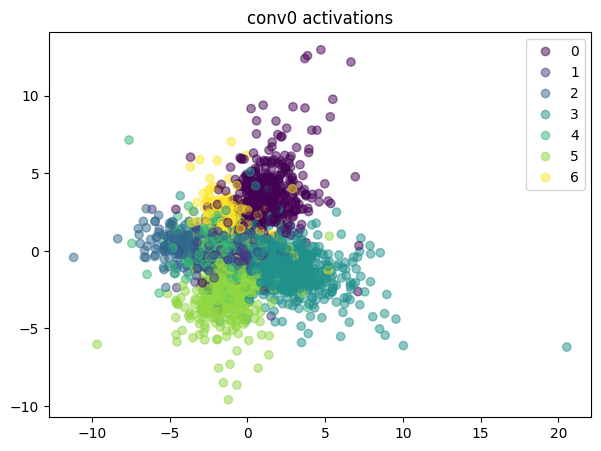

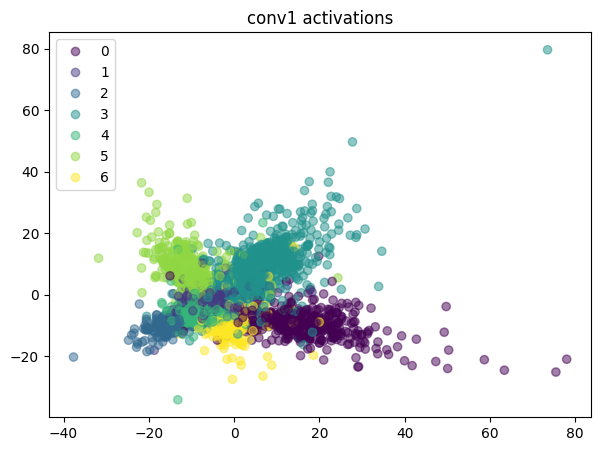

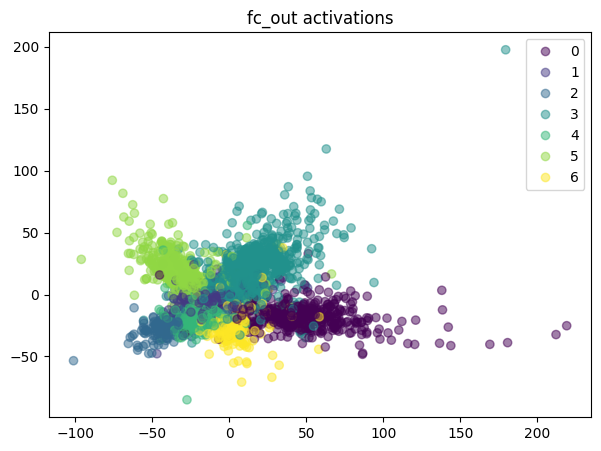

In [37]:
plot_activations_by_class(activations_gcnresid, hgraph_coraca.y)

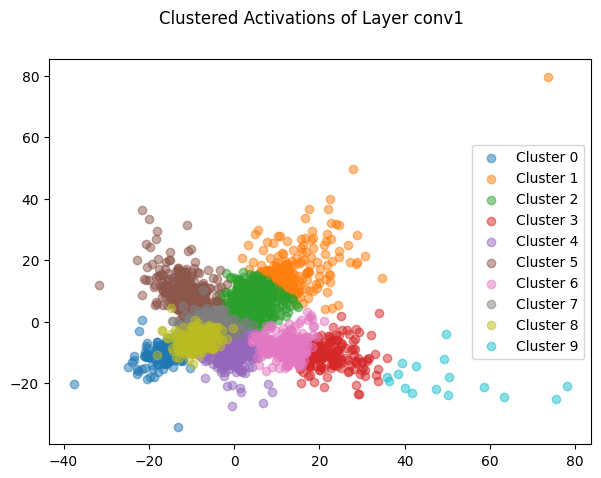

In [49]:
activ_gcnresid, kmeans_model_gcnresid = plot_cluster_activations(activations_gcnresid, 'conv1', num_clusters=10)

# Show concepts

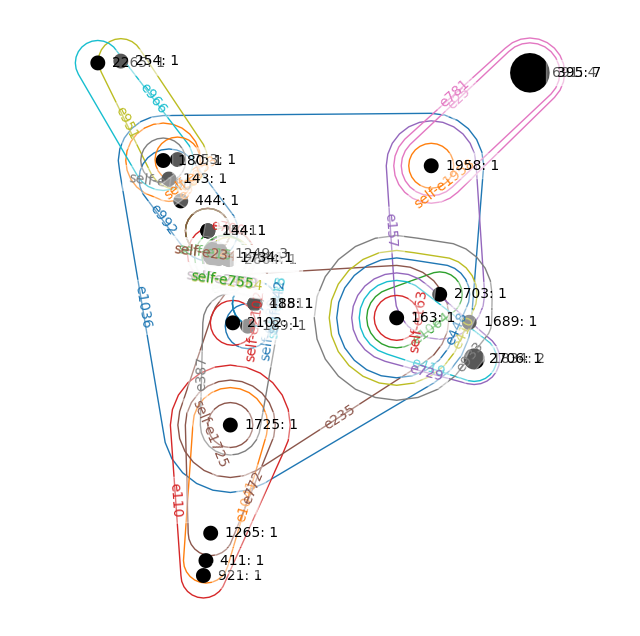

In [26]:
# view neighbours of arbitrary node
foo = get_local_hypergraph(42, hgraph_coraca, num_expansions=2)
hnx.draw(foo.collapse_nodes(), layout=nx.spectral_layout)

## GCN

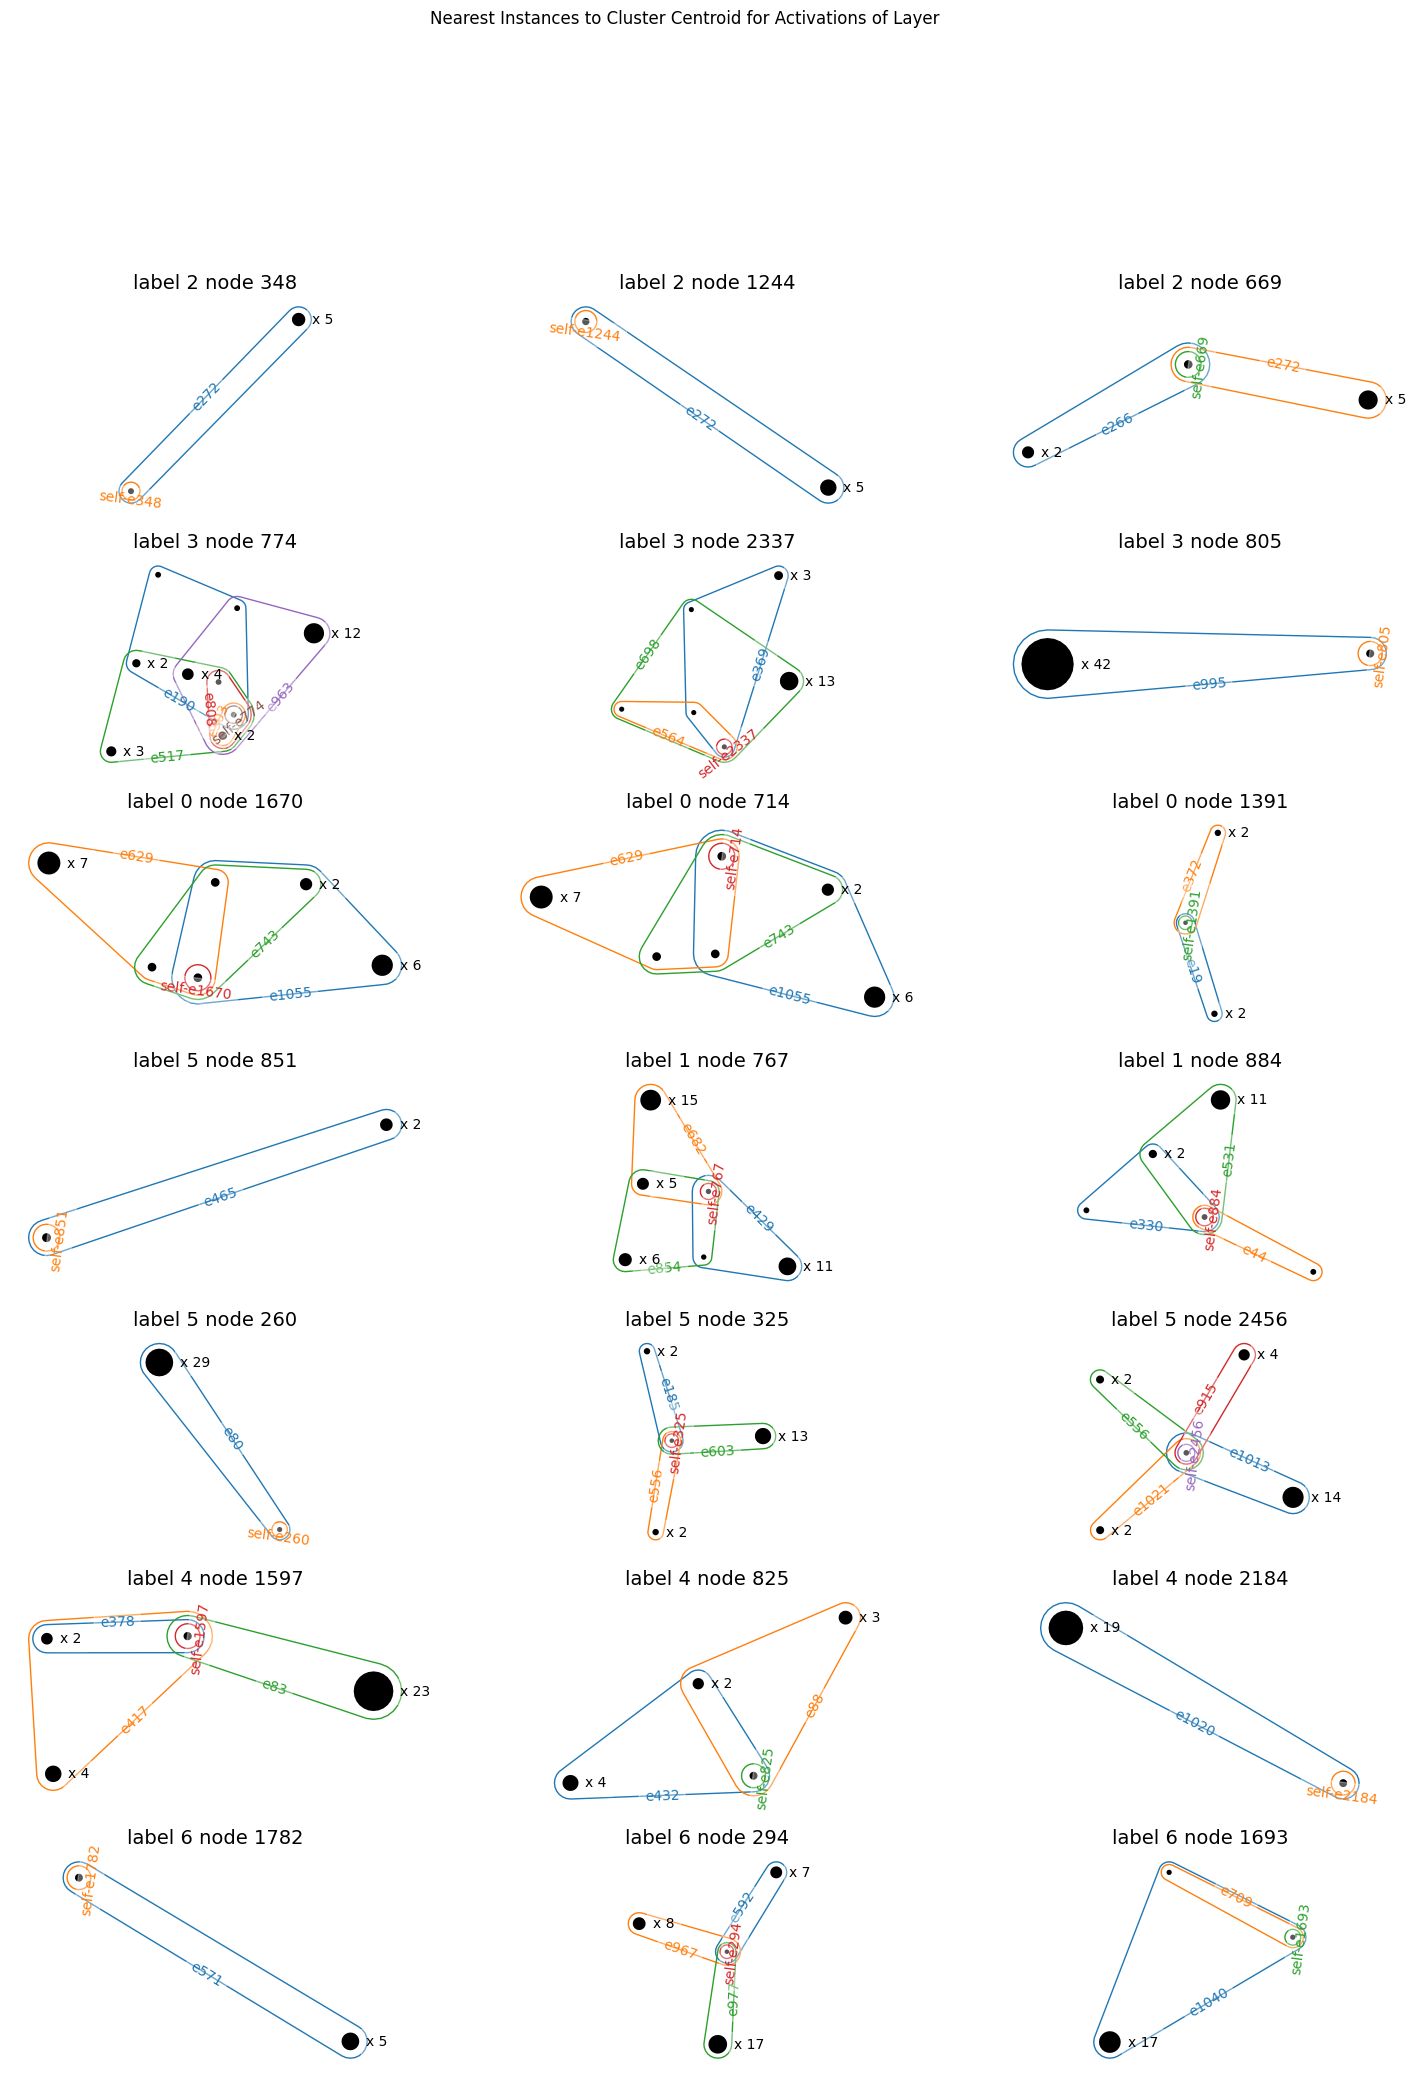

In [39]:
sample_graphs, sample_feats = plot_samples(activ_gcn, kmeans_model_gcn, hgraph_coraca.y, hgraph_coraca, num_expansions=1, num_nodes_view=3)

## GCN residual

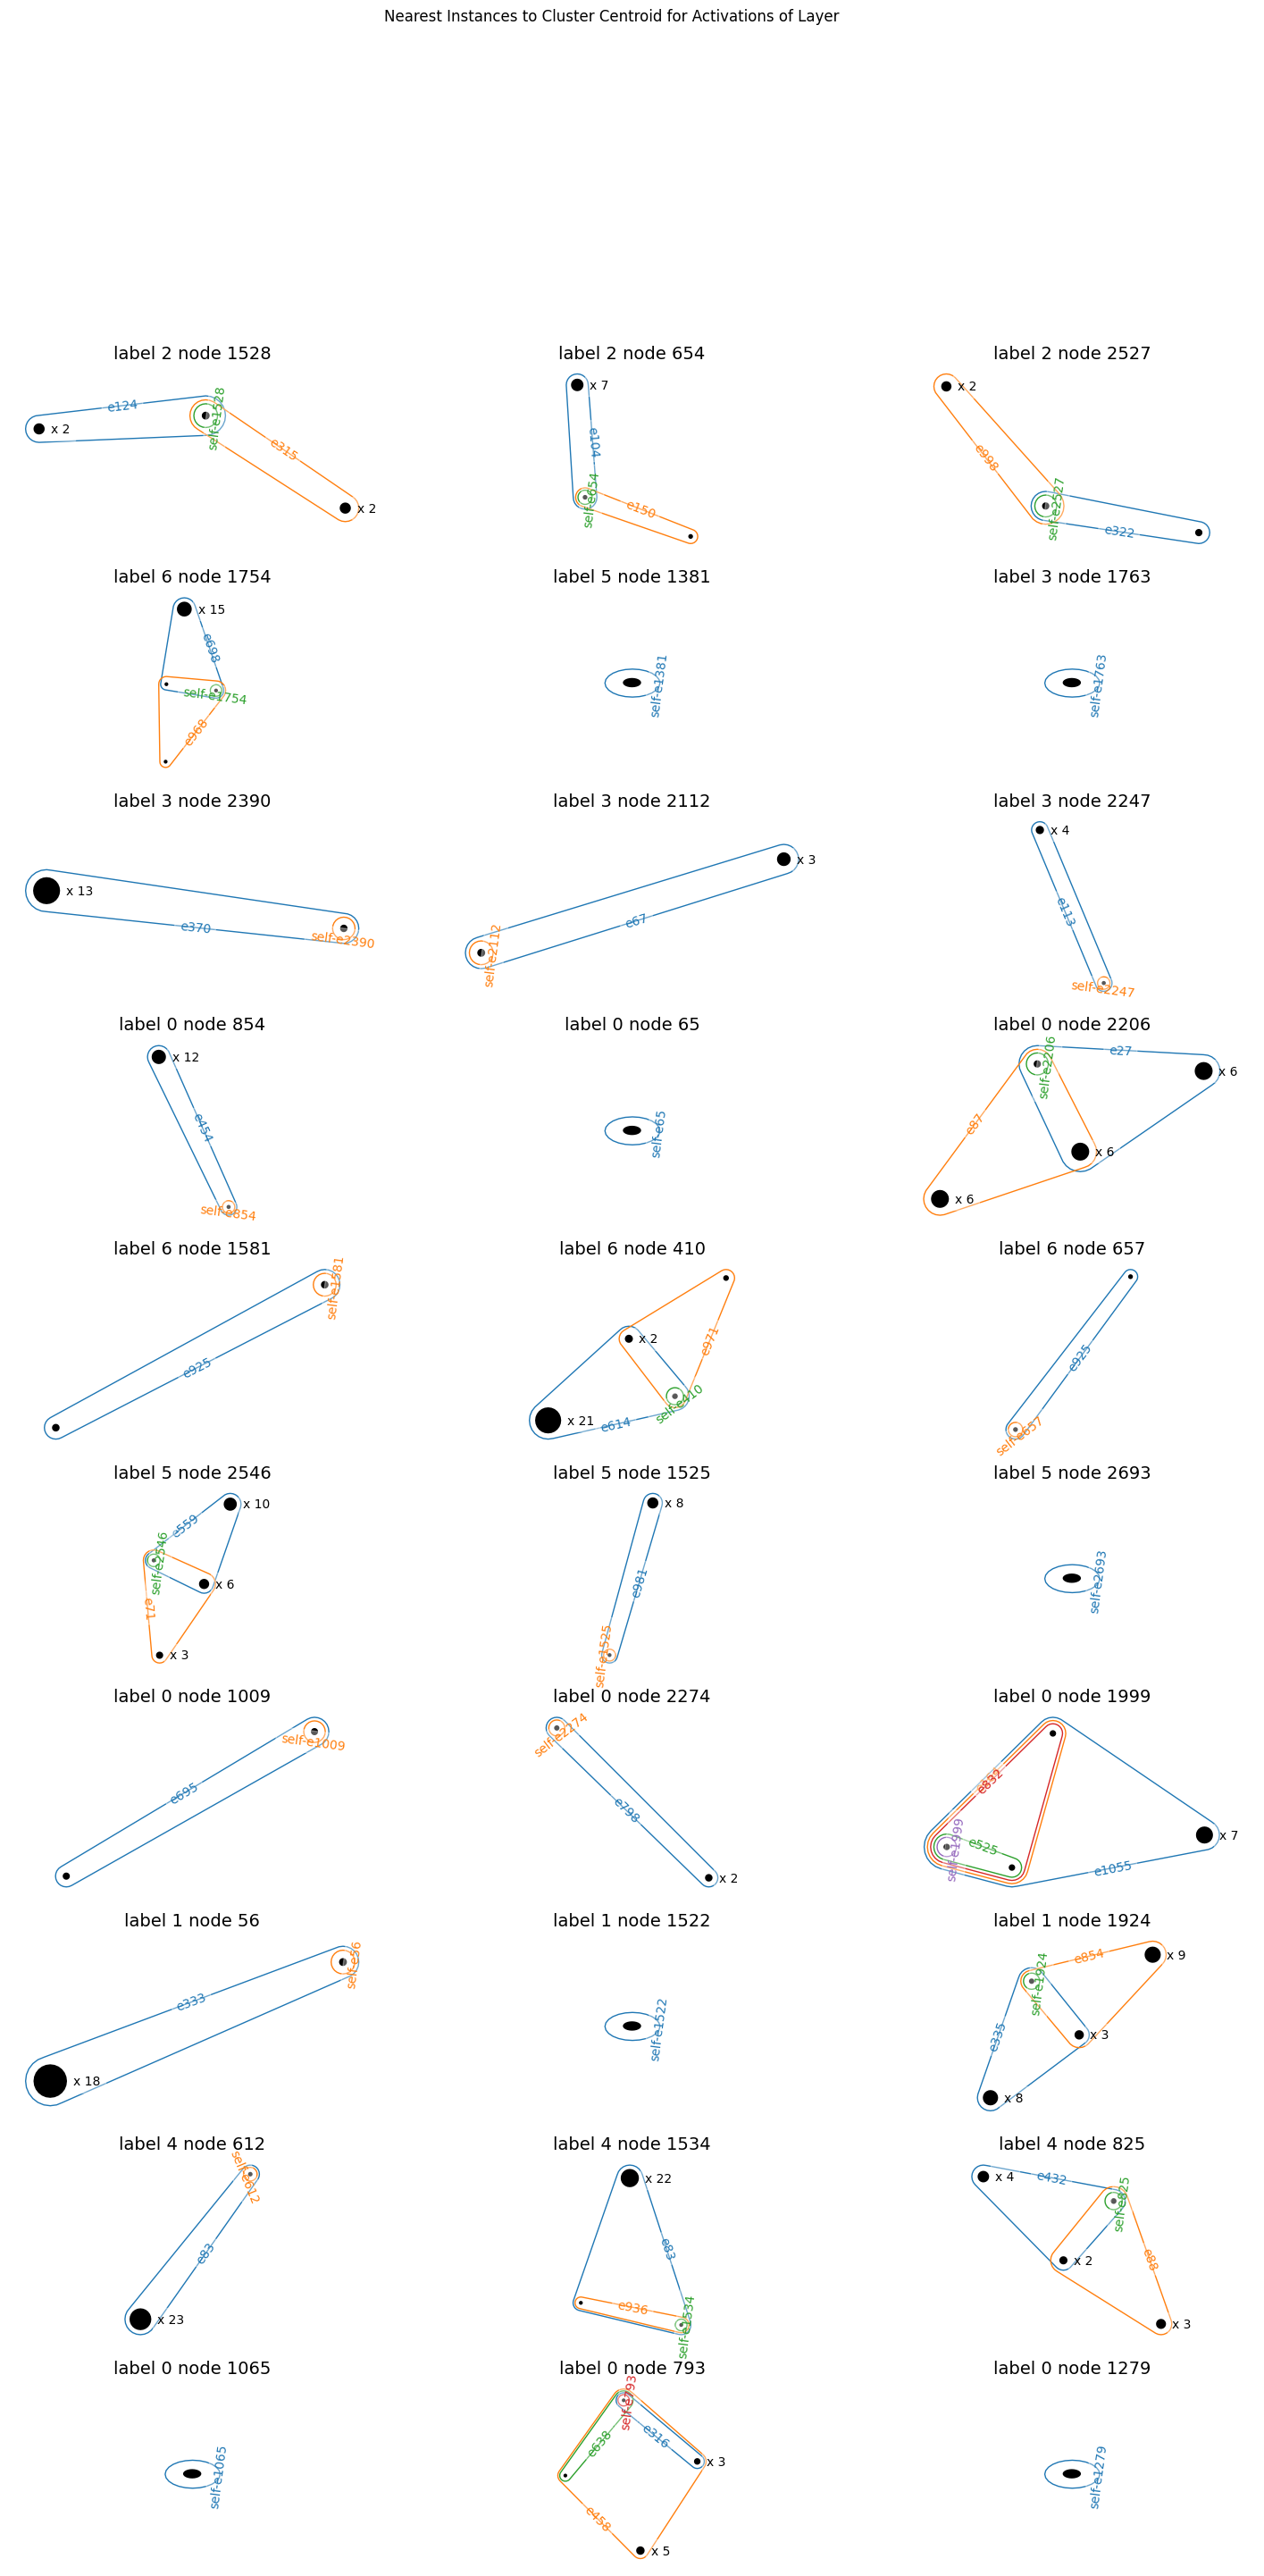

In [52]:
sample_graphs, sample_feats = plot_samples(activ_gcnresid, kmeans_model_gcnresid, hgraph_coraca.y, hgraph_coraca, num_expansions=1, num_nodes_view=3)

# Concept completeness

In [41]:
ac_gcn = ActivationClassifier(
    activ_gcn, kmeans_model_gcn, "decision_tree",
    hgraph_coraca.x.cpu(), hgraph_coraca.y.cpu(), 
    hgraph_coraca.train_mask.cpu(), hgraph_coraca.test_mask.cpu())

In [42]:
ac_gcn.get_classifier_accuracy()

0.8079763663220089

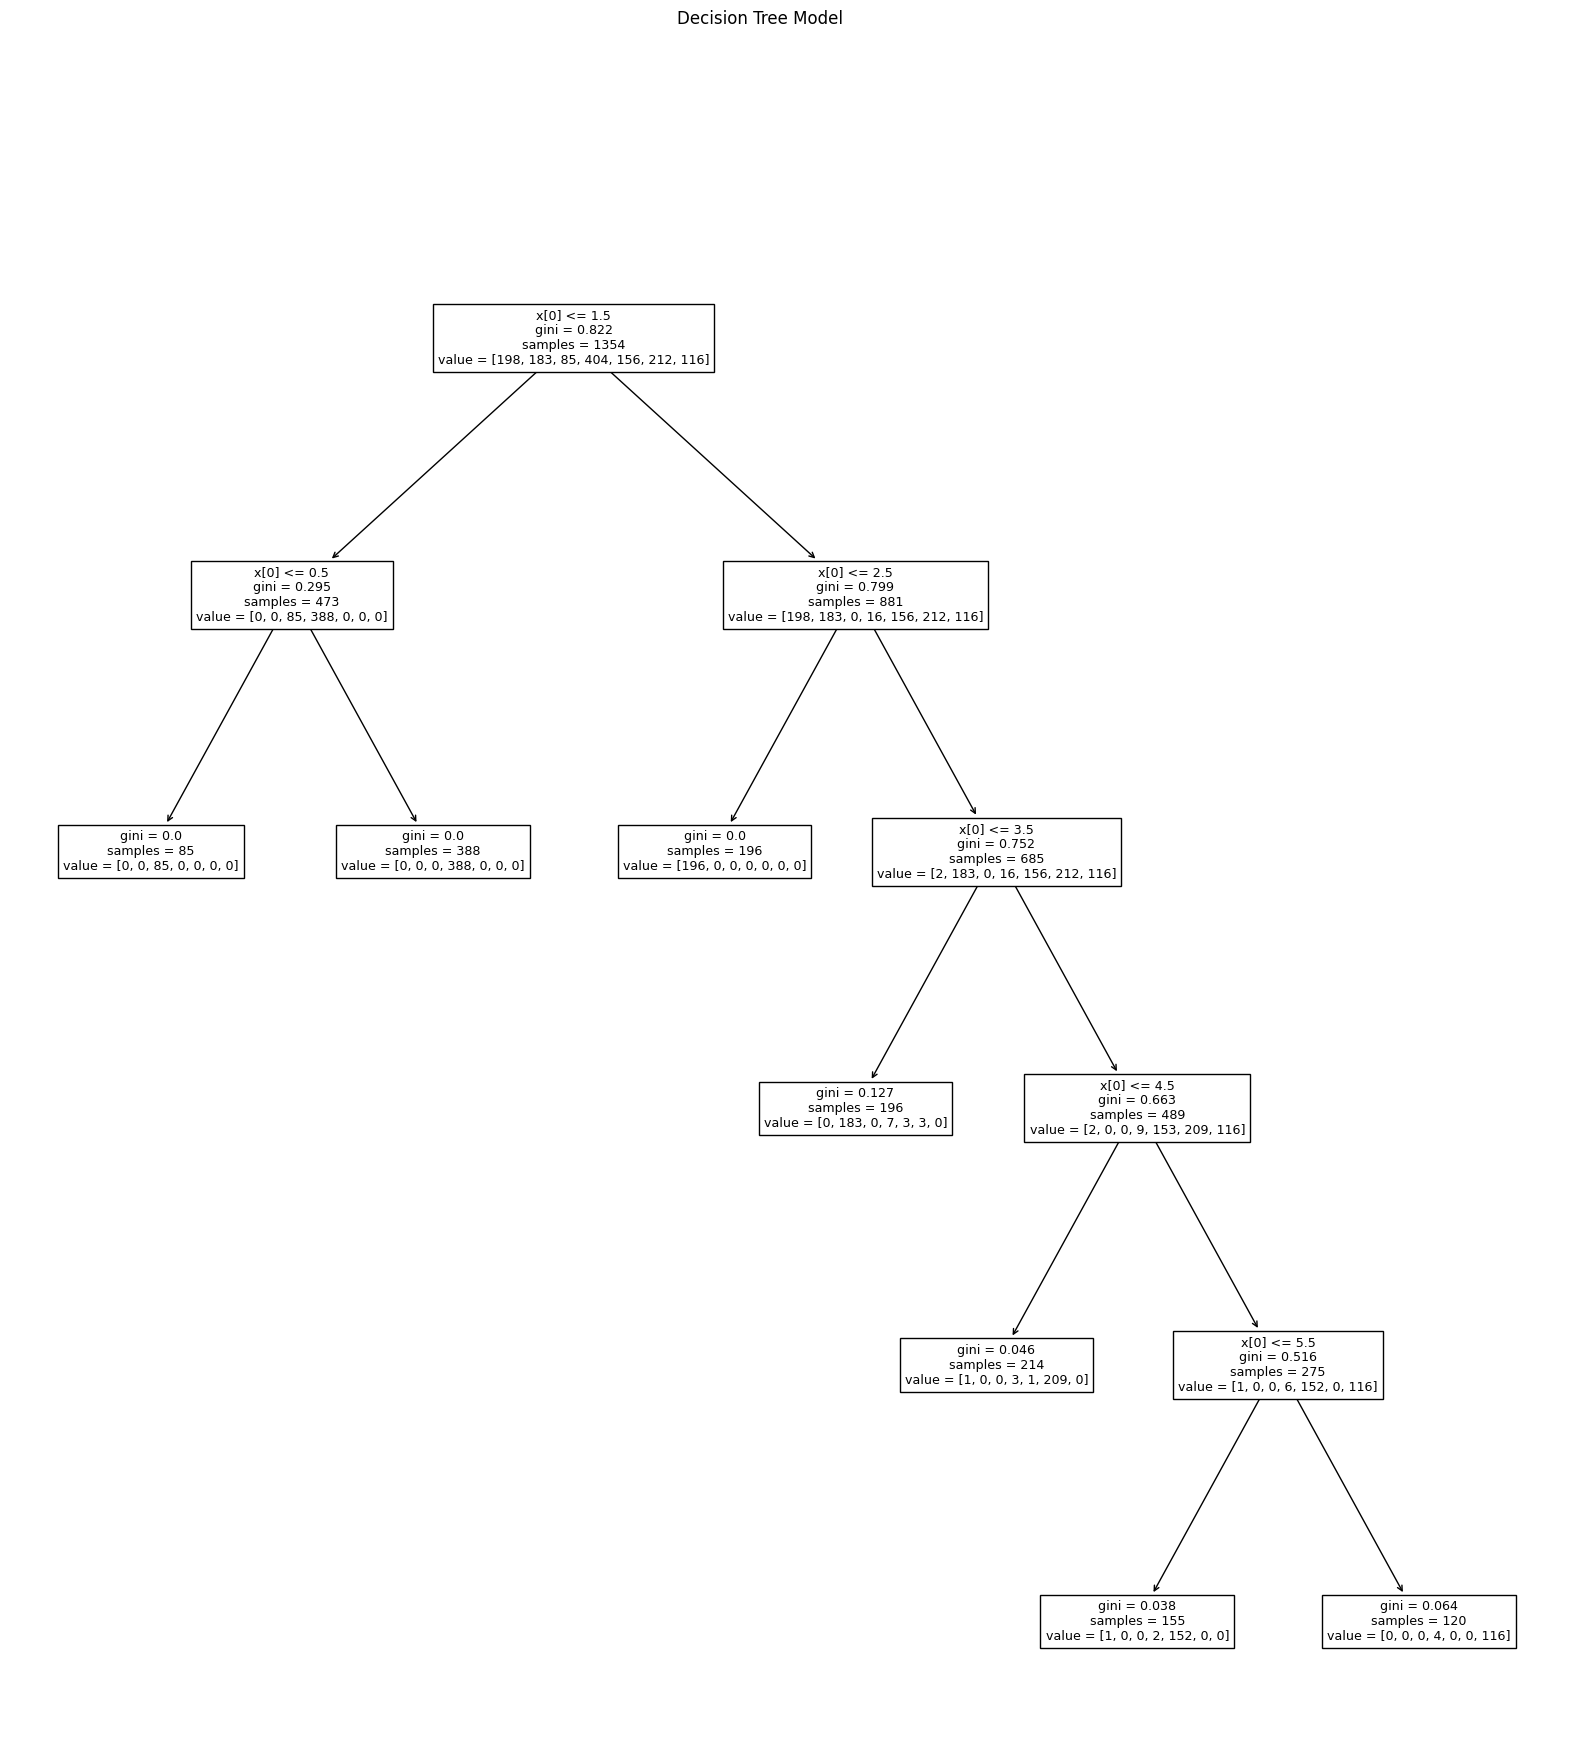

In [43]:
ac_gcn.plot('figures', 'clustered_activs_decisiontree')

In [50]:
ac_gcnresid = ActivationClassifier(
    activ_gcnresid, kmeans_model_gcnresid, "decision_tree",
    hgraph_coraca.x.cpu(), hgraph_coraca.y.cpu(), 
    hgraph_coraca.train_mask.cpu(), hgraph_coraca.test_mask.cpu())

In [51]:
ac_gcnresid.get_classifier_accuracy()

0.7621861152141802